In [55]:
%load_ext autoreload
%autoreload 1

import numpy as np
import os
import pickle
import time
import timeit
import json
import random

os.environ["DGLBACKEND"] = "pytorch"

import dgl
from dgl import from_networkx, node_subgraph

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import src.models as models
# from src.models import GRAPHSAGE, GAT, GCN
from src.dataset.dataset_info import datasets
from src.plot_confusion_matrix import plot_confusion_matrix
from src.calculate_FPR_FNR import calculate_FPR_FNR_with_global

# datasets = {dataset.name: dataset for dataset in datasets_list}

seed = 42  # or any constant value
random.seed(seed)
np.random.seed(seed)
th.manual_seed(seed)

%aimport src.models

num_epochs = 100
batch_size = 16
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# name = "cic_ids_2017_5_percent"
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017"
# name = "nf_bot_iot"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"


with_centralities = False

validate = True
validate_epoch = 1

using_masking = False
masked_class = 2

multi_class = True

use_port_in_address = True
generated_ips = False

graph_type = "line"

window_size= 10000

sort_timestamp = False

dataset = datasets[name]

dataset_folder = os.path.join("datasets", name)
dataset_folder

'datasets\\ccd_inid_modified'

In [57]:
g_type = f"line_graph_{window_size}"

if multi_class:
    g_type += "__multi_class"
    
if with_centralities:
    g_type += "__n_feats"
    
# if k_fold:
#     g_type += f"__{k_fold}_fold"
    
if use_port_in_address:
    g_type += "__ports"
    
if generated_ips:
    g_type += "__generated_ips"
    
if sort_timestamp:
    g_type += "__sorted"
else:
    g_type += "__unsorted"
    
graphs_folder = os.path.join(dataset_folder, g_type)
graphs_folder

'datasets\\ccd_inid_modified\\line_graph_10000__multi_class__ports__unsorted'

In [58]:
number_neighbors = [25, 10]
# number_neighbors = None
num_layers = 2
ndim_out = [128, 128]
aggregation="mean"
# aggregation="pool"
# aggregation="lstm"
# aggregation="gcn"
activation=F.relu
dropout=0.2

my_models = [
    models.LineGraphModel("gcn", models.GCN, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout),
    models.LineGraphModel("graph_sage", models.GRAPHSAGE, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, aggregator_type=aggregation),
    models.LineGraphModel("gat", models.GAT, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout),
]

In [59]:
results_final = {}

results_final["name"] = name
results_final["g_type"] = g_type
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "multi_class": multi_class,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "num_neighbors": number_neighbors,
    "with_centralities": with_centralities,
    "using_masking": using_masking,
    "masked_class_num": masked_class,
    "LAMBD_2": LAMBD_2,
}

results_final["accuracy"] = {}
results_final["f1_score"] = {}
results_final["FPR"] = {}
results_final["FNR"] = {}
results_final["time_elapsed"] = {}
results_final["train_accuracy"] = {}
results_final["train_loss"] = {}
results_final["val_accuracy"] = {}
results_final["val_loss"] = {}
results_final["val_precision"] = {}
results_final["val_recall"] = {}
results_final["val_f1"] = {}
results_final["val_FPR"] = {}
results_final["val_FNR"] = {}

for m in my_models:
    results_final[m.model_name] = {}
    results_final["accuracy"][m.model_name] = []
    results_final["time_elapsed"][m.model_name] = []
    results_final["train_accuracy"][m.model_name] = []
    results_final["train_loss"][m.model_name] = []
    results_final["val_accuracy"][m.model_name] = []
    results_final["val_loss"][m.model_name] = []
    results_final["val_precision"][m.model_name] = []
    results_final["val_recall"][m.model_name] = []
    results_final["val_f1"][m.model_name] = []
    results_final["val_FPR"][m.model_name] = []
    results_final["val_FNR"][m.model_name] = []

results_final

{'name': 'ccd_inid_modified',
 'g_type': 'line_graph_10000__multi_class__ports__unsorted',
 'configuration': {'num_epochs': 100,
  'multi_class': True,
  'batch_size': 16,
  'learning_rate': 0.001,
  'num_neighbors': [25, 10],
  'with_centralities': False,
  'using_masking': False,
  'masked_class_num': 2,
  'LAMBD_2': 0.001},
 'accuracy': {'gcn': [], 'graph_sage': [], 'gat': []},
 'f1_score': {},
 'FPR': {},
 'FNR': {},
 'time_elapsed': {'gcn': [], 'graph_sage': [], 'gat': []},
 'train_accuracy': {'gcn': [], 'graph_sage': [], 'gat': []},
 'train_loss': {'gcn': [], 'graph_sage': [], 'gat': []},
 'val_accuracy': {'gcn': [], 'graph_sage': [], 'gat': []},
 'val_loss': {'gcn': [], 'graph_sage': [], 'gat': []},
 'val_precision': {'gcn': [], 'graph_sage': [], 'gat': []},
 'val_recall': {'gcn': [], 'graph_sage': [], 'gat': []},
 'val_f1': {'gcn': [], 'graph_sage': [], 'gat': []},
 'val_FPR': {'gcn': [], 'graph_sage': [], 'gat': []},
 'val_FNR': {'gcn': [], 'graph_sage': [], 'gat': []},
 'gcn'

In [60]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20250121-224833'

In [61]:
results_folder_path = "results"
results_folder_path1 = os.path.join(results_folder_path, name)
results_folder_path2 = os.path.join(results_folder_path1, g_type)
folder_path = os.path.join(results_folder_path2, dtime)
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
os.makedirs(confusion_matrices_path, exist_ok=True)
os.makedirs("temp", exist_ok=True)
# os.makedirs(confusion_matrices_path, exist_ok=True)

In [62]:
labels = ["Normal", "Attack"]
num_classes = 2
if multi_class:
    with open(os.path.join(dataset_folder, "labels_names.pkl"), "rb") as f:
        labels_names = pickle.load(f)
    labels_mapping = labels_names[0]
    # labels = labels_names[1]
    labels = list(labels_mapping.values())
    num_classes = len(labels)
labels, num_classes

([np.str_('arp_dos'),
  np.str_('hydra_brute'),
  np.str_('mitm'),
  np.str_('none'),
  np.str_('slowloris'),
  np.str_('udp_dos')],
 6)

In [63]:
if using_masking:
    results_final["configuration"]["masked_class_name"] = str(labels[masked_class])

In [64]:
dataset_folder_path = None
dataset_folder_path_train = os.path.join(graphs_folder, "training", "graphs")
dataset_folder_path_val = os.path.join(graphs_folder, "validation", "graphs")
dataset_folder_path_test = os.path.join(graphs_folder, "testing", "graphs")

In [65]:
node_attrs = ['h', dataset.label_col, dataset.class_num_col]
# node_attrs = ['h', dataset.label_col, dataset.class_num_col, "index"]
# read training, validation, and testing graphs
if dataset_folder_path:
    graphs = []
    for file in os.listdir(dataset_folder_path):
        # print(f"==>> file: {os.path.join(dataset_folder_path_train, file)}")
        with open(os.path.join(dataset_folder_path, file), "rb") as f:
            G = pickle.load(f)
            # print(list(G.nodes(data=True))[0])
            G = from_networkx(G,node_attrs=node_attrs)
            node_label = G.ndata[dataset.label_col]
            # if len(node_label.unique()) > 1:
            #     print(f"==>> node_label.unique(): {len(node_label.unique())}")
                
            graphs.append(G)

            # break
            
    training_graphs, testing_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
    len(training_graphs)

In [66]:
if dataset_folder_path_train:
    training_graphs = []
    training_labels = []
    for file in os.listdir(dataset_folder_path_train):
        with open(os.path.join(dataset_folder_path_train, file), "rb") as f:
            G = pickle.load(f)
            # print(list(G.nodes(data=True))[0])
            G = from_networkx(G,node_attrs=node_attrs)

            if using_masking:
                training_mask = G.ndata[dataset.class_num_col] != masked_class
                G = node_subgraph(G, training_mask)
                
            if multi_class:
                node_labels = G.ndata[dataset.class_num_col]
            else:
                node_labels = G.ndata[dataset.label_col]
                
            training_graphs.append(G)
            training_labels.append(node_labels)
    len(training_graphs)

In [67]:
if dataset_folder_path_val:
    validation_graphs = []
    for file in os.listdir(dataset_folder_path_val):
        with open(os.path.join(dataset_folder_path_val, file), "rb") as f:
            G = pickle.load(f)
            G = from_networkx(G,node_attrs=node_attrs)
            validation_graphs.append(G)
    len(validation_graphs)

In [68]:
if dataset_folder_path_test:
    testing_graphs = []
    for file in os.listdir(dataset_folder_path_test):
        with open(os.path.join(dataset_folder_path_test, file), "rb") as f:
            G = pickle.load(f)
            G = from_networkx(G,node_attrs=node_attrs)
            testing_graphs.append(G)
    len(testing_graphs)

In [69]:
G0 = training_graphs[0]
num_features = G.ndata['h'].shape[1]

In [70]:
concat_training_labels = th.cat(training_labels).numpy()

In [71]:
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(concat_training_labels),
                                                y=concat_training_labels)

In [72]:
if using_masking:
    class_weights=np.insert(class_weights, masked_class, 0)

In [73]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [74]:
def compute_accuracy(pred, labels):
    # return (pred == labels).float().mean().item()
    correct = 0
    total = len(labels)
    # Count correct predictions
    correct = np.sum(np.array(pred) == np.array(labels))

    # Compute accuracy
    accuracy = correct / total if total > 0 else 0
    return accuracy


In [75]:
class GraphDataset(th.utils.data.Dataset):
    def __init__(self, graphs):
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

In [76]:
train_dataset = GraphDataset(training_graphs)
val_dataset = GraphDataset(validation_graphs)
test_dataset = GraphDataset(testing_graphs)

In [77]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dgl.batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=dgl.batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dgl.batch)

In [78]:
def evaluate_model(model, loader, labels, results_f, epoch, loss_fn, model_name):
    start_time = timeit.default_timer()
    model.eval()
    all_preds = []
    all_labels = []
    
    total_val_loss = 0.0
    total_samples = 0
    with th.no_grad():
        for batched_graph in loader:
            features = batched_graph.ndata['h']
            labels_batch = batched_graph.ndata[dataset.class_num_col if multi_class else dataset.label_col]
            logits = model(batched_graph, features)
            loss = loss_fn(logits, labels_batch)
            
            this_batch_size = labels_batch.size(0)
            total_val_loss += loss.item() * this_batch_size
            total_samples += this_batch_size
            
            preds = th.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    elapsed = timeit.default_timer() - start_time
    val_loss = total_val_loss / total_samples if total_samples > 0 else 0.0
    # print(f"Time for validation: {elapsed:.4f}")
    # Compute metrics
    actual = all_labels
    test_pred = all_preds
    
    if multi_class:
        actual = np.vectorize(labels_names[0].get)(actual)
        test_pred = np.vectorize(labels_names[0].get)(test_pred)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in actual]
        test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)
    
    val_acc = cr["accuracy"] * 100
    val_precision = cr['weighted avg']['precision'] * 100
    val_recall = cr['weighted avg']['recall'] * 100
    val_f1 = cr['weighted avg']['f1-score'] * 100
    cm = confusion_matrix(actual, test_pred, labels=labels)

    results_fpr_fnr = calculate_FPR_FNR_with_global(cm)
    
    # Log metrics
    results_f["val_accuracy"][model_name].append(val_acc)
    results_f["val_loss"][model_name].append(val_loss)
    results_f["val_precision"][model_name].append(val_precision)
    results_f["val_recall"][model_name].append(val_recall)
    results_f["val_f1"][model_name].append(val_f1)
    results_f["val_FPR"][model_name].append(results_fpr_fnr["global"]["FPR"])
    results_f["val_FNR"][model_name].append(results_fpr_fnr["global"]["FNR"])

    return val_acc, val_loss, elapsed


In [79]:
def train_model(line_graph_model: models.LineGraphModel, train_loader, val_loader, num_epochs, lr):
    
    if line_graph_model.model_class == models.GRAPHSAGE:
        line_graph_model.training_model = line_graph_model.model_class(num_features, ndim_out=line_graph_model.ndim_out, aggregator_type = line_graph_model.aggregator_type, n_classes=num_classes)
        line_graph_model.best_model = line_graph_model.model_class(num_features, ndim_out=line_graph_model.ndim_out, aggregator_type = line_graph_model.aggregator_type, n_classes=num_classes)
    else:
        line_graph_model.training_model = line_graph_model.model_class(num_features, ndim_out=line_graph_model.ndim_out, n_classes=num_classes)
        line_graph_model.best_model = line_graph_model.model_class(num_features, ndim_out=line_graph_model.ndim_out, n_classes=num_classes)
        
    optimizer = th.optim.Adam(line_graph_model.training_model.parameters(), lr=lr, weight_decay=LAMBD_2)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    # if multi_class:
    #     loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    # else:
    #     loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)
    best_val_acc = 0

    print("================================")
    print("================================")
    print(f"Training Model: {line_graph_model.model_name}")
    
    for epoch in range(num_epochs):
        
        all_training_preds = []
        all_training_labels = []
    
        total_train_loss = 0.0
        total_samples = 0
    
        line_graph_model.training_model.train()
        for batched_graph in train_loader:
            features = batched_graph.ndata['h']
            actual_labels = batched_graph.ndata[dataset.class_num_col if multi_class else dataset.label_col]

            logits = line_graph_model.training_model(batched_graph, features)
            loss = loss_fn(logits, actual_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            this_batch_size = actual_labels.size(0)
            total_train_loss += loss.item() * this_batch_size
            total_samples += this_batch_size
            
            preds = th.argmax(logits, dim=-1)
            all_training_preds.extend(preds.cpu().numpy())
            all_training_labels.extend(actual_labels.cpu().numpy())
        
        pred = all_training_preds
        actual_labels = all_training_labels
        train_acc = compute_accuracy(pred, actual_labels)  * 100
        train_loss = total_train_loss / total_samples if total_samples > 0 else 0.0
        # print("Model: {} -- Epoch: {} -- Training acc: {:.5f}".format(line_graph_model.model_name, epoch, compute_accuracy(pred, actual_labels)))
        print(f"Model: {line_graph_model.model_name} -- Epoch: {epoch} -- Training acc: {train_acc:.2f} -- Training loss: {train_loss:.4f}")
        results_final["train_accuracy"][line_graph_model.model_name].append(train_acc)
        results_final["train_loss"][line_graph_model.model_name].append(train_loss)
        
        # Validation step
        val_acc, val_loss, elapsed = evaluate_model(
            line_graph_model.training_model, 
            val_loader, 
            labels, 
            results_final, 
            epoch,
            loss_fn = loss_fn,
            model_name=line_graph_model.model_name
        )
        print(f"Model: {line_graph_model.model_name} -- Epoch: {epoch} -- Validation acc: {val_acc:.2f} -- Validation loss: {val_loss:.4f}")
        print(f"Time for validation: {elapsed:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = line_graph_model.training_model.state_dict().copy()
            # th.save(best_model_state, f"temp/best_model_{line_graph_model.model_name}.pth")
            th.save(line_graph_model.training_model, f"temp/best_model_{line_graph_model.model_name}.pth")
            
    line_graph_model.best_model.load_state_dict(best_model_state)


In [80]:
def test_model(model, loader, labels, model_name, results_f):
    print("=======================")
    print(f"testing model: {model_name}")

    start_time = timeit.default_timer()
    
    # Run evaluation
    all_preds = []
    all_labels = []
    
    model.eval()
    with th.no_grad():
        for batched_graph in loader:
            features = batched_graph.ndata['h']
            labels_batch = batched_graph.ndata[dataset.class_num_col if multi_class else dataset.label_col]  # Adjust to 'class' for multi-class
            logits = model(batched_graph, features)
            preds = th.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    elapsed = timeit.default_timer() - start_time
    # Compute metrics
    actual = all_labels
    test_pred = all_preds
    
    
    if multi_class:
        actual = np.vectorize(labels_names[0].get)(actual)
        test_pred = np.vectorize(labels_names[0].get)(test_pred)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in actual]
        test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)

    cm = confusion_matrix(actual, test_pred, labels=labels)
    cm_normalized = confusion_matrix(actual, test_pred, labels=labels, normalize="true")
    results_fpr_fnr = calculate_FPR_FNR_with_global(cm)


    # Log metrics
    results_f[model_name]["elapsed"] = elapsed
    results_f[model_name]["classification_report"] = cr
    results_f[model_name]["results_fpr_fnr"] = results_fpr_fnr
    results_f["accuracy"][model_name] = cr["accuracy"] * 100
    results_f["f1_score"][model_name] = cr['weighted avg']['f1-score'] * 100
    results_f["FPR"][model_name] = results_fpr_fnr["global"]["FPR"]
    results_f["FNR"][model_name] = results_fpr_fnr["global"]["FNR"]
    results_f["time_elapsed"][model_name] = elapsed


    print(classification_report(actual, test_pred, digits=4, zero_division=0))
    
    return actual, test_pred, cm, cm_normalized


### Training GNN models

In [81]:
# %autoreload

In [82]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

Training Model: gcn
Model: gcn -- Epoch: 0 -- Training acc: 16.77 -- Training loss: 1.8979
Model: gcn -- Epoch: 0 -- Validation acc: 41.12 -- Validation loss: 1.7773
Time for validation: 0.2673
Model: gcn -- Epoch: 1 -- Training acc: 30.29 -- Training loss: 1.7610
Model: gcn -- Epoch: 1 -- Validation acc: 62.51 -- Validation loss: 1.7592
Time for validation: 0.1337
Model: gcn -- Epoch: 2 -- Training acc: 44.81 -- Training loss: 1.6643
Model: gcn -- Epoch: 2 -- Validation acc: 64.88 -- Validation loss: 1.7405
Time for validation: 0.1486
Model: gcn -- Epoch: 3 -- Training acc: 53.92 -- Training loss: 1.5827
Model: gcn -- Epoch: 3 -- Validation acc: 65.28 -- Validation loss: 1.7214
Time for validation: 0.1282
Model: gcn -- Epoch: 4 -- Training acc: 57.64 -- Training loss: 1.5282
Model: gcn -- Epoch: 4 -- Validation acc: 66.86 -- Validation loss: 1.7017
Time for validation: 0.1315
Model: gcn -- Epoch: 5 -- Training acc: 60.43 -- Training loss: 1.4818
Model: gcn -- Epoch: 5 -- Validation ac

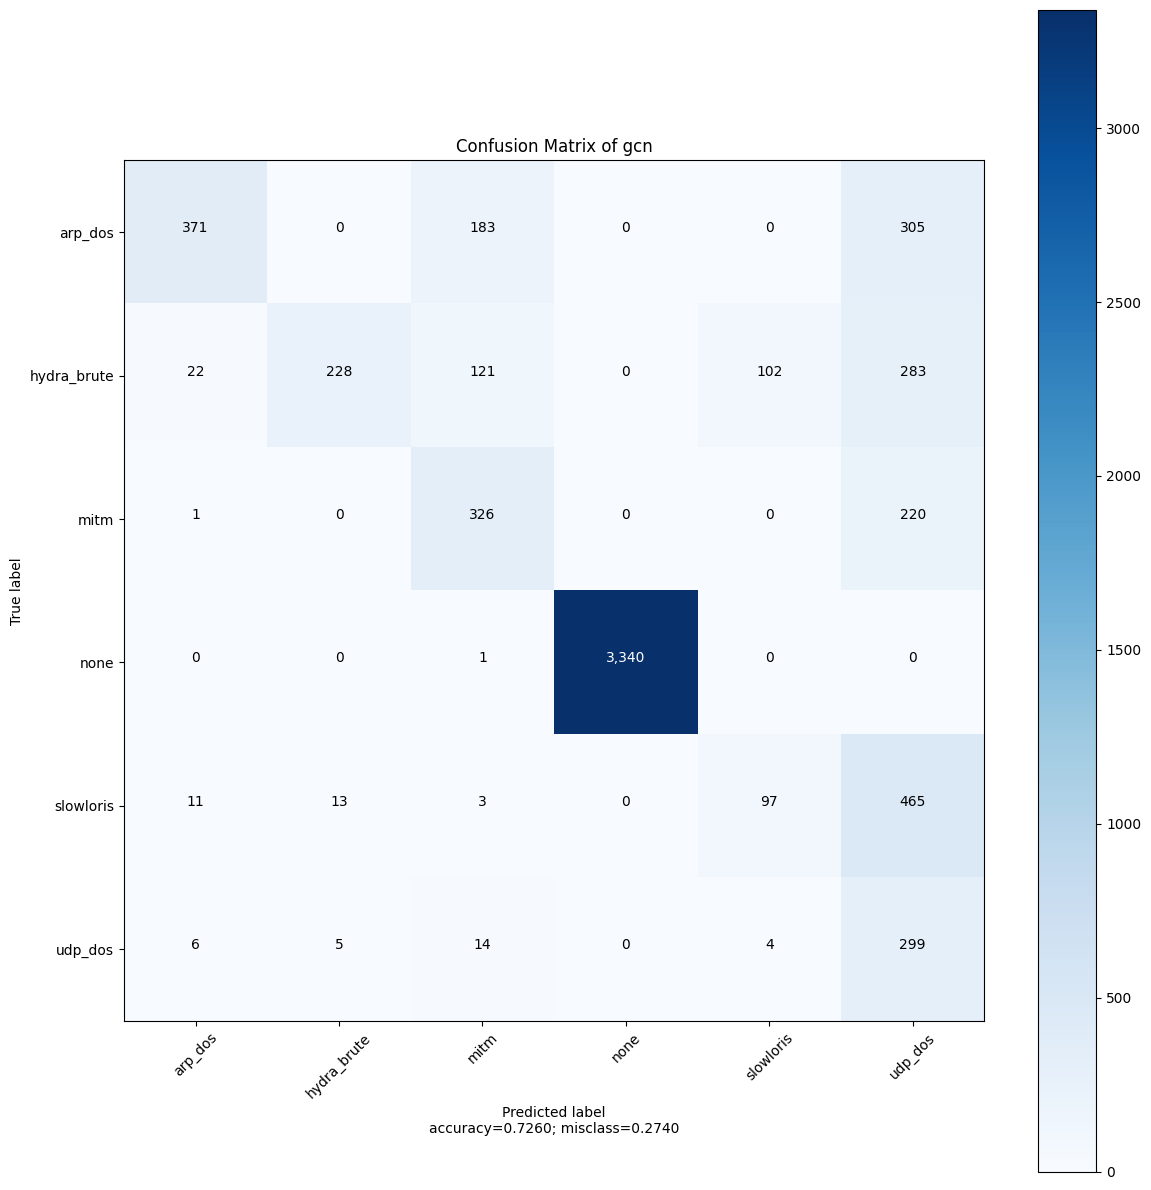

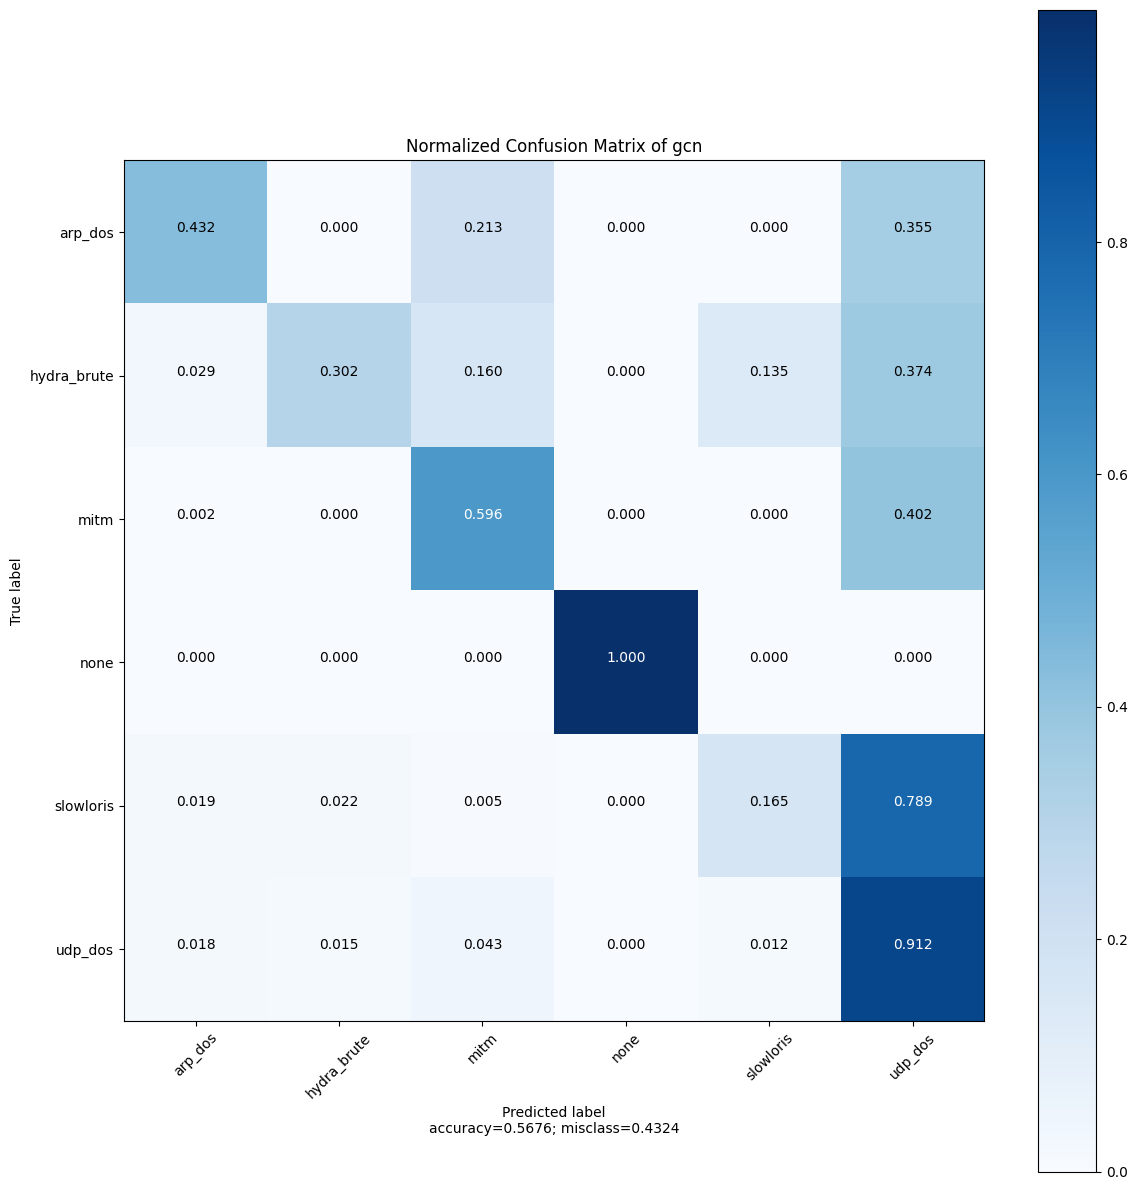

Training Model: graph_sage
Model: graph_sage -- Epoch: 0 -- Training acc: 13.67 -- Training loss: 1.8893
Model: graph_sage -- Epoch: 0 -- Validation acc: 21.86 -- Validation loss: 1.7515
Time for validation: 0.1136
Model: graph_sage -- Epoch: 1 -- Training acc: 24.66 -- Training loss: 1.7767
Model: graph_sage -- Epoch: 1 -- Validation acc: 49.65 -- Validation loss: 1.6924
Time for validation: 0.1190
Model: graph_sage -- Epoch: 2 -- Training acc: 35.36 -- Training loss: 1.6917
Model: graph_sage -- Epoch: 2 -- Validation acc: 52.39 -- Validation loss: 1.6343
Time for validation: 0.1177
Model: graph_sage -- Epoch: 3 -- Training acc: 44.49 -- Training loss: 1.6165
Model: graph_sage -- Epoch: 3 -- Validation acc: 68.64 -- Validation loss: 1.5778
Time for validation: 0.1329
Model: graph_sage -- Epoch: 4 -- Training acc: 51.14 -- Training loss: 1.5557
Model: graph_sage -- Epoch: 4 -- Validation acc: 71.48 -- Validation loss: 1.5223
Time for validation: 0.1270
Model: graph_sage -- Epoch: 5 -- 

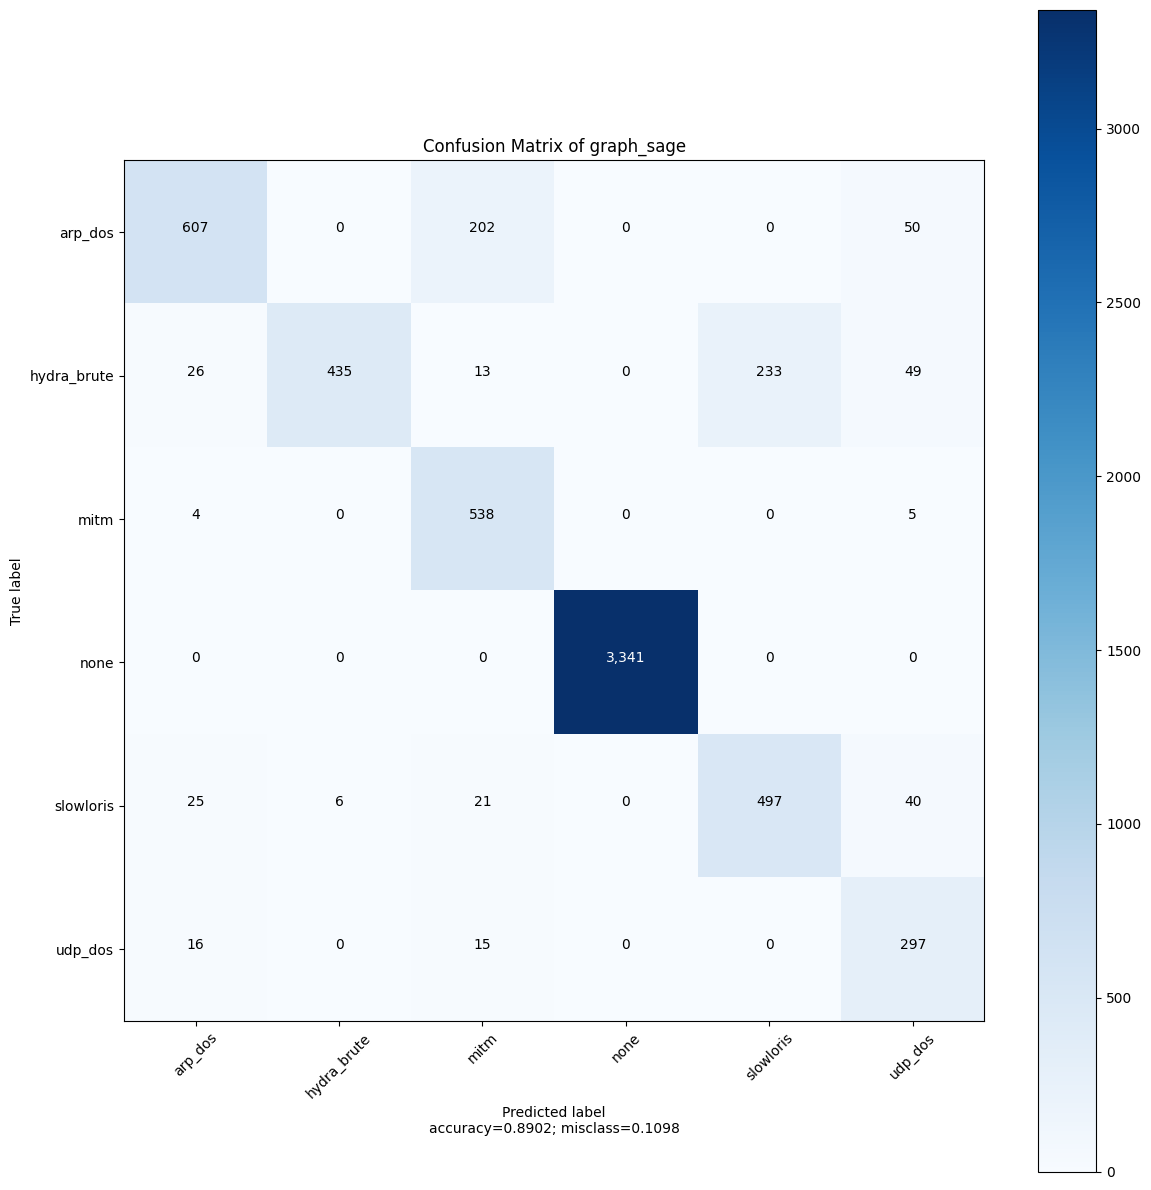

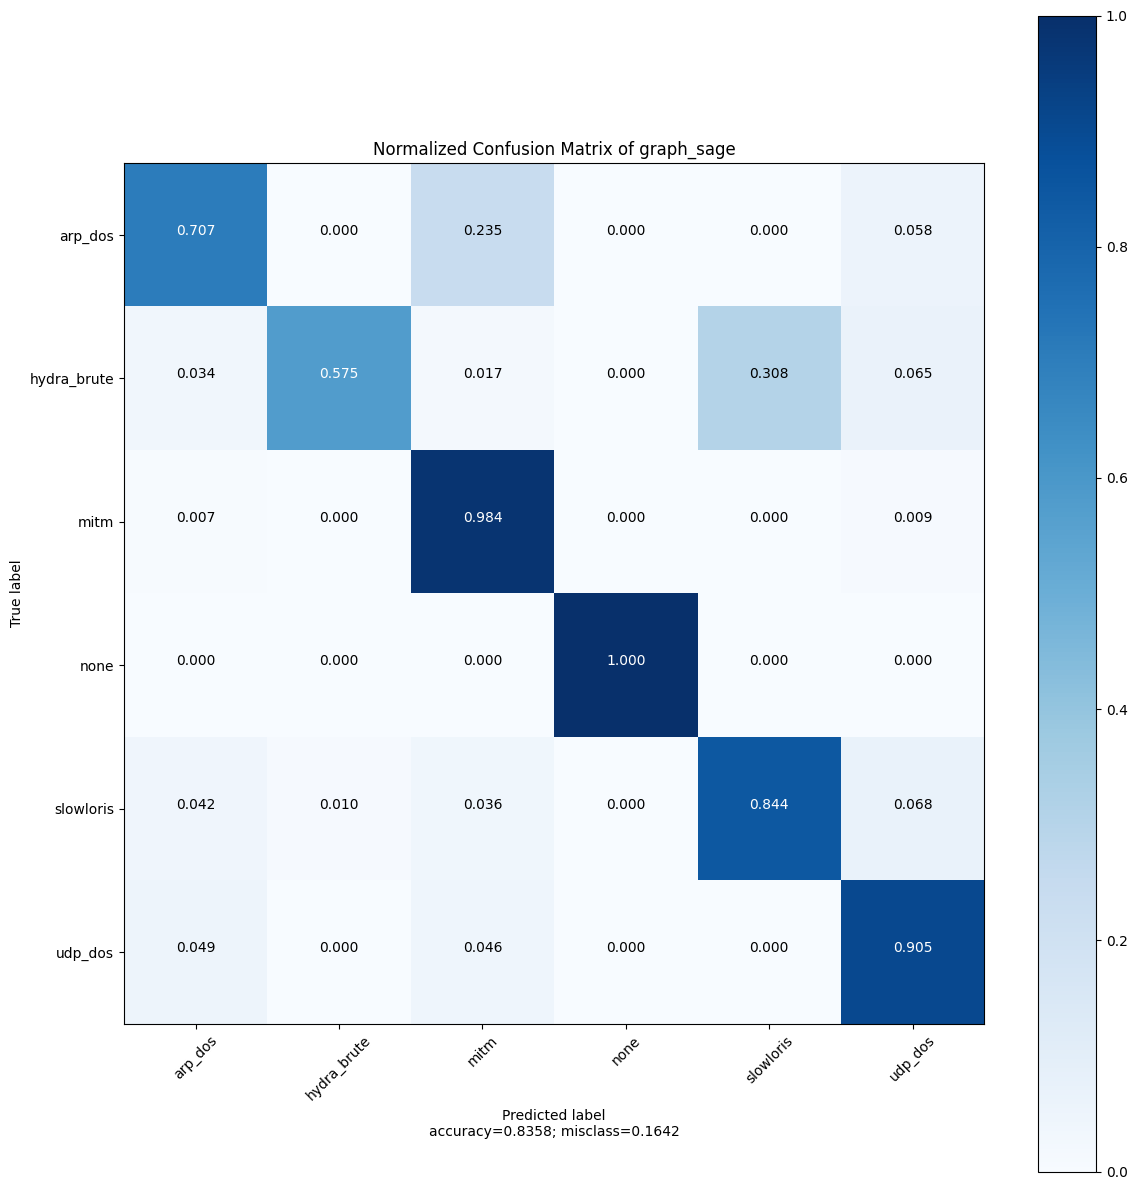

Training Model: gat
Model: gat -- Epoch: 0 -- Training acc: 13.81 -- Training loss: 1.8702
Model: gat -- Epoch: 0 -- Validation acc: 11.77 -- Validation loss: 1.7889
Time for validation: 1.3729
Model: gat -- Epoch: 1 -- Training acc: 24.05 -- Training loss: 1.7639
Model: gat -- Epoch: 1 -- Validation acc: 11.77 -- Validation loss: 1.7843
Time for validation: 1.3116
Model: gat -- Epoch: 2 -- Training acc: 36.61 -- Training loss: 1.7019
Model: gat -- Epoch: 2 -- Validation acc: 11.77 -- Validation loss: 1.7796
Time for validation: 1.1046
Model: gat -- Epoch: 3 -- Training acc: 45.82 -- Training loss: 1.6446
Model: gat -- Epoch: 3 -- Validation acc: 11.77 -- Validation loss: 1.7746
Time for validation: 1.1281
Model: gat -- Epoch: 4 -- Training acc: 51.00 -- Training loss: 1.5939
Model: gat -- Epoch: 4 -- Validation acc: 30.53 -- Validation loss: 1.7690
Time for validation: 1.4553
Model: gat -- Epoch: 5 -- Training acc: 55.18 -- Training loss: 1.5436
Model: gat -- Epoch: 5 -- Validation ac

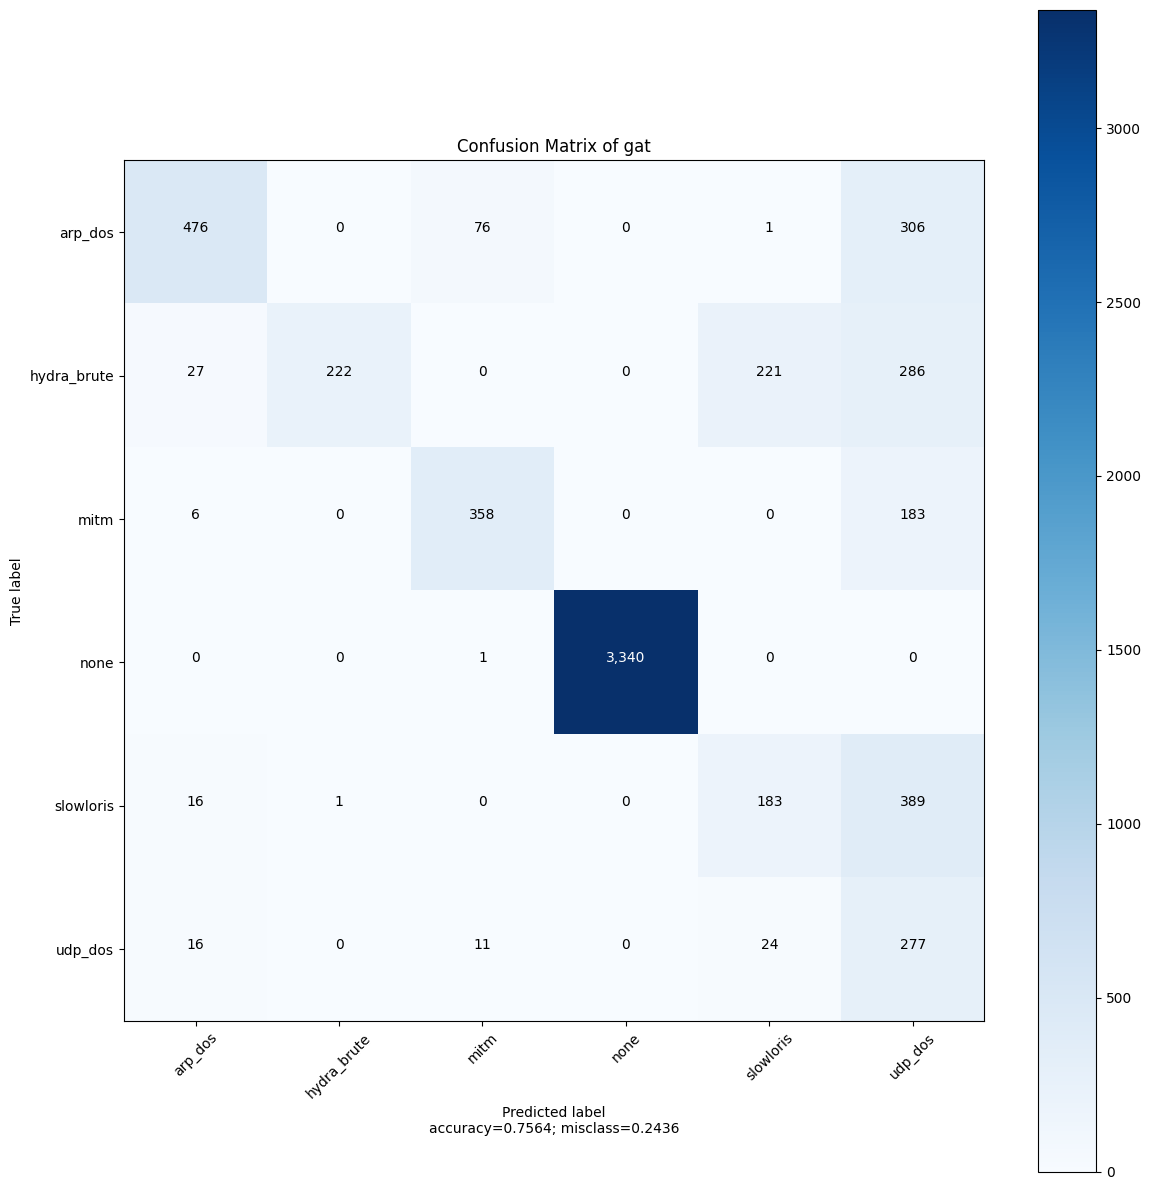

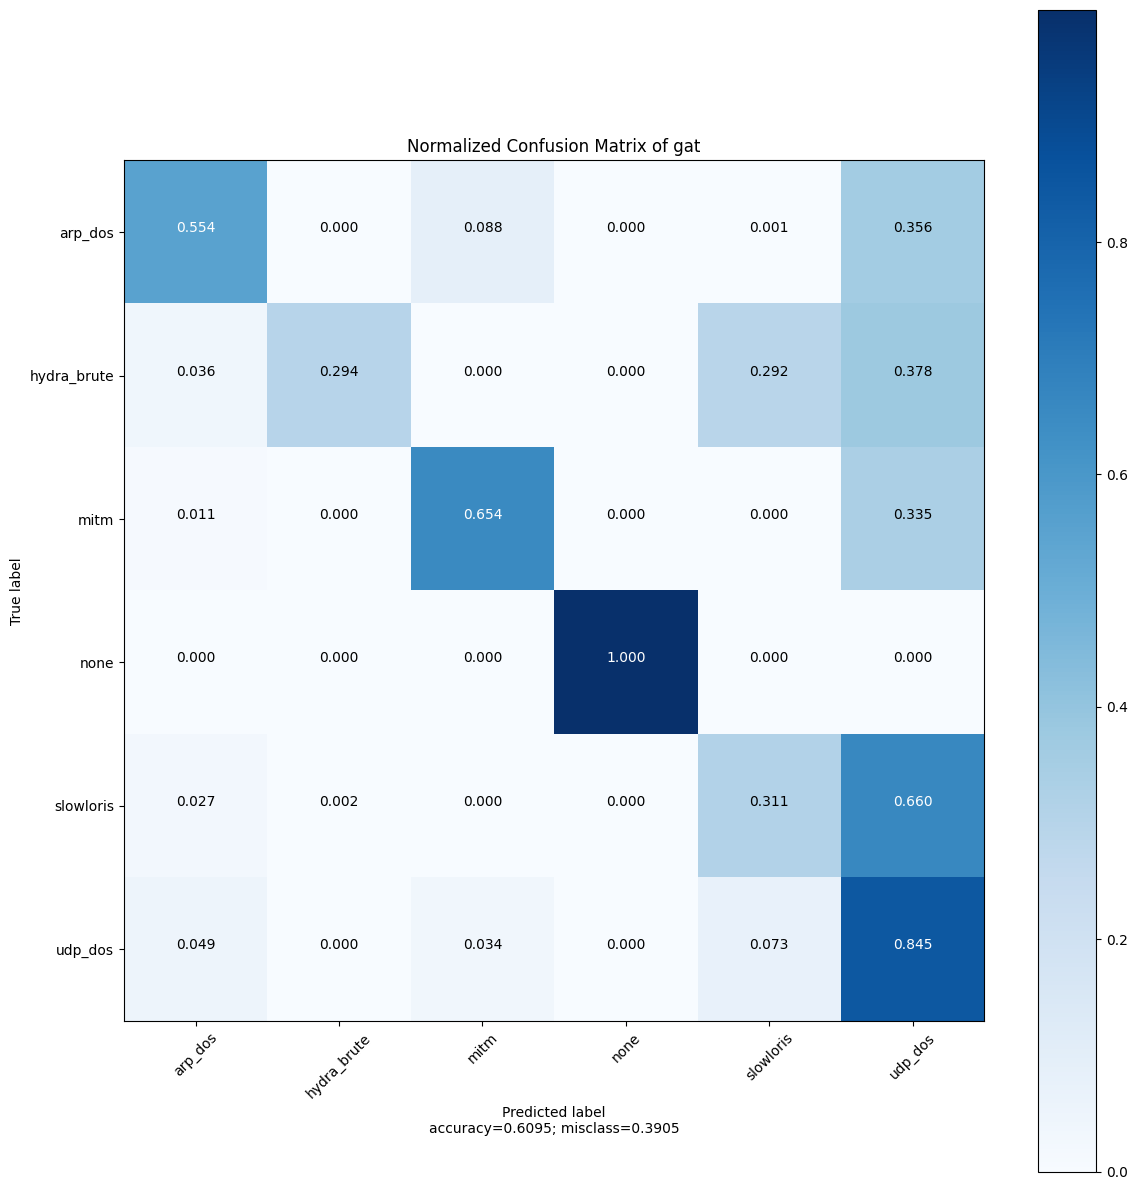

In [83]:
for m in my_models:
    train_model(m, train_loader, val_loader, num_epochs, learning_rate)
    # cm = test_model(m, G_test, test_labels, results_final, labels)
    actual, test_pred, cm, cm_normalized = test_model(m.best_model, test_loader, labels, m.model_name, results_final)
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title=f"Confusion Matrix of {m.model_name}",
                          file_path=f"{confusion_matrices_path}/{m.model_name}.png")
    
    plot_confusion_matrix(cm=cm_normalized,
                          normalize=False,
                          normalized=True,
                          target_names=labels,
                          title=f"Normalized Confusion Matrix of {m.model_name}",
                          file_path=f"{confusion_matrices_path}/{m.model_name}_normalized.png")
    
    with open(os.path.join(folder_path, "actual.json"), "w") as f:
        f.writelines(json.dumps(actual, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, f"{m.model_name}_pred.json"), "w") as f:
        f.writelines(json.dumps(test_pred, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, "results.json"), "w") as f:
        f.writelines(json.dumps(results_final, cls=NumpyEncoder))

In [84]:
# for m in my_models:
#     m.best_model = th.load(f"temp/best_model_{m.model_name}.pth")
        
#     # cm = test_model(m, G_test, test_labels, results_final, labels)
#     actual, test_pred, cm, cm_normalized = test_model(m.best_model, test_loader, labels, m.model_name, results_final)
#     plot_confusion_matrix(cm=cm,
#                           normalize=False,
#                           target_names=labels,
#                           title=f"Confusion Matrix of {m.model_name}",
#                           file_path=f"{confusion_matrices_path}/{m.model_name}.png")
    
#     plot_confusion_matrix(cm=cm_normalized,
#                           normalize=False,
#                           normalized=True,
#                           target_names=labels,
#                           title=f"Normalized Confusion Matrix of {m.model_name}",
#                           file_path=f"{confusion_matrices_path}/{m.model_name}_normalized.png")
    
#     with open(os.path.join(folder_path, "actual.json"), "w") as f:
#         f.writelines(json.dumps(actual, cls=NumpyEncoder))
        
#     with open(os.path.join(folder_path, f"{m.model_name}_pred.json"), "w") as f:
#         f.writelines(json.dumps(test_pred, cls=NumpyEncoder))
        
#     with open(os.path.join(folder_path, "results.json"), "w") as f:
#         f.writelines(json.dumps(results_final, cls=NumpyEncoder))